In [2]:
%cd ..

c:\Users\justi\coding\Uni\MA


In [3]:
import glob
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Plot Classification Errors and Fitness

Single Onset Experiments

In [3]:
run_number = 0
error_file = f"./experiments/fixed_shifted_pitch_2000gen/{run_number}_errors.pkl"
fitness_file = f"./experiments/fixed_shifted_pitch_1000gen/{run_number}_fitnesses.pkl"

In [4]:
with open(error_file, "rb") as fp:
    errors = pickle.load(fp)
with open(fitness_file, "rb") as fp:
    fitnesses = pickle.load(fp) 

# Parse errors into types
errors_padded = []
max_len = max([len(run) for run in errors])
for run in errors:
    while len(run) < max_len:
        run.append((0, 0, 0))
    errors_padded.append(run)
j_i_runs = [[tup[0] for tup in run] for run in errors_padded]
j_p_runs = [[tup[1] for tup in run] for run in errors_padded]
j_ip_runs = [[tup[2] for tup in run] for run in errors_padded]
j_i_means = np.mean(j_i_runs, axis=0)
j_p_means = np.mean(j_p_runs, axis=0)
j_ip_means = np.mean(j_ip_runs, axis=0)
j_i_means.shape

(2000,)

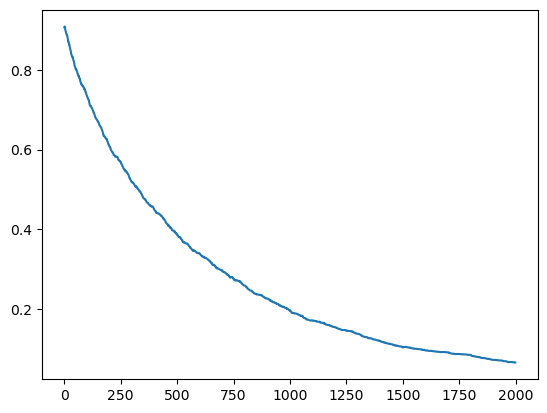

In [5]:
plt.plot(j_i_means)

Multi-Onsets Experiments (Full Piece)

<Axes: xlabel='Generation', ylabel='Mean Jaccard Error'>

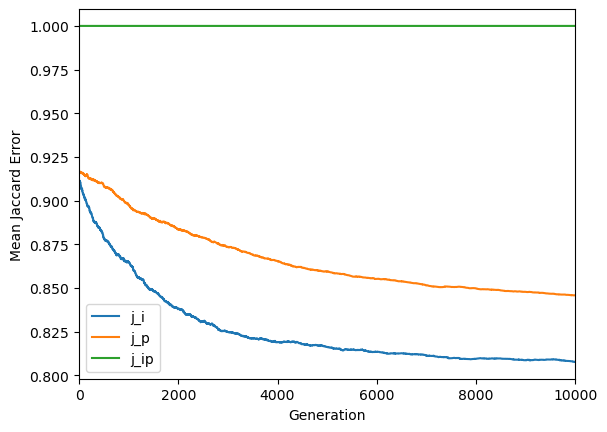

In [16]:
experiment_name = "tiny_aam/300_1_10000_0.05_5_10_1_20_0.9954_15_10_1sec_convlog"
root_path = f"./experiments/{experiment_name}/"
csv_files = glob.glob(root_path + "**/*.csv", recursive=True)
j_i, j_p, j_ip, fitness = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    j_i = pd.concat([j_i, df["j_i"]], axis=1)
    j_p = pd.concat([j_p, df["j_p"]], axis=1)
    j_ip = pd.concat([j_ip, df["j_ip"]], axis=1)
    fitness = pd.concat([fitness, df["fitness"]], axis=1)
df = pd.DataFrame({"j_i":list(j_i.mean(axis=1)), "j_p":list(j_p.mean(axis=1)), "j_ip":list(j_ip.mean(axis=1))})
df_fit = fitness.mean(axis=1)
df.plot(xlabel="Generation", ylabel="Mean Jaccard Error", xlim=(0, 10000))

<Axes: xlabel='Generations', ylabel='Mean Fitness'>

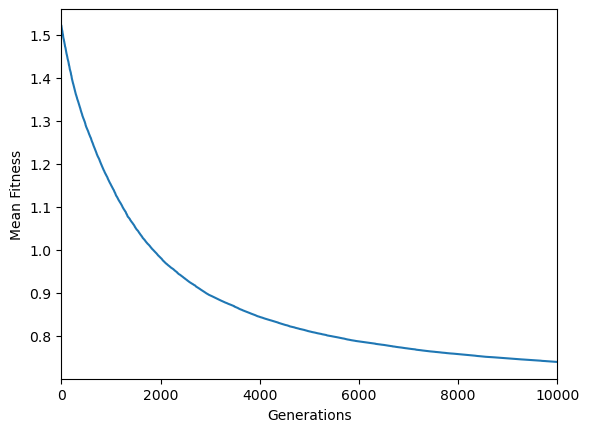

In [15]:
df_fit.plot(xlabel="Generations", ylabel="Mean Fitness", xlim=(0, 10000))